# Generation of test dataset

Here, I explore [DrugMechDB](https://sulab.github.io/DrugMechDB/) which could ideally provide us with true positive paths / MOAs.

In [1]:
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
import json
import networkx as nx
import matplotlib.pyplot as plt

from pubchempy import get_compounds
from collections import Counter

## Load in the DrugMechDB file

In [2]:
KG_DIR = '../data/kg'
VALIDATION_DIR = '../data/validation'
MAPPING_DIR = '../data/mappings'

In [3]:
node_names_df = pd.read_excel(f'{VALIDATION_DIR}/indication_MOA_paths.xlsx', sheet_name='paths')
node_names_df.head(2)

,n1,e1,n2,e2,n3,e3,n4,e4,n5,e5,n6,e6,n7,e7,n8
0,imatinib,INHIBITS,BCR/ABL,CAUSES,CML (ph+),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,imatinib,INHIBITS,c-Kit,UP_REGULATES,Cellular proliferation,CAUSES,Systemic mast cell disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
node_type_df = pd.read_excel(f'{VALIDATION_DIR}/indication_MOA_paths.xlsx', sheet_name='metapaths')
node_ids_df = pd.read_excel(f'{VALIDATION_DIR}/indication_MOA_paths.xlsx', sheet_name='node_ids')

In [5]:
node_ids_df.head(2)

,n1,n2,n3,n4,n5,n6,n7,n8
0,MESH:D000068877,UniProt:P00519,MESH:D015464,NaN,NaN,NaN,NaN,NaN
1,MESH:D000068877,UniProt:P10721,GO:0008283,MESH:D034721,NaN,NaN,NaN,NaN


In [6]:
node_type_df.head(2)

,n1,e1,n2,e2,n3,e3,n4,e4,n5,e5,n6,e6,n7,e7,n8
0,Drug,INHIBITS,Protein,CAUSES,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Drug,INHIBITS,Protein,UP_REGULATES,Biological Process,CAUSES,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Get all drug-bp pairs

From the main file, each row is a valide drug-bp path. So each path is considered individually and only paths that connect a drug to a biological process are selected.

In [7]:
drug_bp_pairs = []

for idx, row in tqdm(node_type_df.iterrows(), total=node_type_df.shape[0]):
    try:
        assert row['n1'] == 'Drug'
        drug_node = {
            'idx': node_ids_df.iloc[idx]['n1'], 
            'name': node_names_df.iloc[idx]['n1']
        }
    except AssertionError:
        continue

    for _index in range(1, 8):
        if row[f'n{_index}'] == 'Biological Process':
            drug_bp_pairs.append((drug_node, {
                'idx': node_ids_df.iloc[idx][f'n{_index}'], 
                'name': node_names_df.iloc[idx][f'n{_index}']
            }))

len(drug_bp_pairs)


100%|██████████| 123/123 [00:00<00:00, 11145.42it/s]


101

# Harmonization of nodes to consistent ontology

For compounds nodes, we will ground them to pubchem nodes and see overlap

In [8]:
drug2mech_harmonized_edges = []
drug_id_mapping = {}

for cmp_node, bp_node in tqdm(drug_bp_pairs):
    compound = get_compounds(cmp_node['name'], 'name')
    if len(compound) == 0:
        continue

    cidx = 'pubchem.compound:' + str(compound[0].cid)
    drug_id_mapping[cmp_node['name']] = cidx
    
    drug2mech_harmonized_edges.append({
        'source': cidx,
        'source_node_type': 'Compound',
        'target': bp_node['idx'],
        'target_node_type': 'Biological Process',
        'edge_type': 'induces'
    })

len(drug2mech_harmonized_edges)

100%|██████████| 101/101 [01:40<00:00,  1.00it/s]


95

In [9]:
validation_df = pd.DataFrame(drug2mech_harmonized_edges)
validation_df.drop_duplicates(inplace=True)
validation_df.head()

,source,source_node_type,target,target_node_type,edge_type
0,pubchem.compound:5291,Compound,GO:0008283,Biological Process,induces
2,pubchem.compound:1983,Compound,GO:0001659,Biological Process,induces
3,pubchem.compound:2244,Compound,GO:0007596,Biological Process,induces
5,pubchem.compound:156391,Compound,GO:0006954,Biological Process,induces
6,pubchem.compound:4539,Compound,GO:0006260,Biological Process,induces


In [10]:
validation_df.shape

(86, 5)

## Now, get those which are connected to our KG:

We know they're already connected if both the drug and BP are already in the KG:

In [11]:
combined_kg = pd.read_csv(f'{KG_DIR}/full_kg.tsv', sep='\t')
combined_kg.head(2)

,source,target,edge_type,source_node_type,target_node_type
0,ncbigene:6622,ncbigene:3308,interacts,Gene,Gene
1,ncbigene:6622,GO:0043065,participates,Gene,Biological Process


In [12]:
bps = set(combined_kg[combined_kg['target'].str.startswith('GO')]['target'].tolist())
drugs = set(combined_kg[combined_kg['source'].str.startswith('pubchem')]['source'].tolist())

In [13]:
validation_df.loc[(validation_df['source'].isin(drugs)) & (validation_df['target'].isin(bps))]

,source,source_node_type,target,target_node_type,edge_type


Proteins:

In [14]:
target_sets = set(combined_kg[combined_kg['target'].str.startswith('ncbigene')]['target'].tolist())
source_sets = set(combined_kg[combined_kg['source'].str.startswith('ncbigene')]['source'].tolist())
proteins_in_kg = target_sets.union(source_sets)
len(proteins_in_kg)

1652

In [15]:
uniprot2ncbi = pd.read_csv(
    's3://enveda-datascience/lauren/gene_mapping.tsv', 
    sep='\t',
    usecols=['NCBI Gene ID(supplied by NCBI)', 'UniProt ID(supplied by UniProt)'],
    dtype=str,
)
uniprot2ncbi.dropna(subset=['UniProt ID(supplied by UniProt)'], inplace=True)
uniprot2ncbi.head(2)

,NCBI Gene ID(supplied by NCBI),UniProt ID(supplied by UniProt)
0,1,P04217
2,29974,Q9NQ94


In [16]:
uniprot2ncbi['NCBI Gene ID(supplied by NCBI)'] = 'ncbigene:' + uniprot2ncbi['NCBI Gene ID(supplied by NCBI)']
uniprot2ncbi['UniProt ID(supplied by UniProt)'] = 'UniProt:' + uniprot2ncbi['UniProt ID(supplied by UniProt)']
uniprot2ncbi.set_index('UniProt ID(supplied by UniProt)', inplace=True)
uniprot2ncbi = uniprot2ncbi.to_dict()['NCBI Gene ID(supplied by NCBI)']
len(uniprot2ncbi)

20156

In [17]:
# write a dictionary to a json file
with open(f'{MAPPING_DIR}/uniprot2ncbi.json', 'w') as f:
    json.dump(uniprot2ncbi, f)

Now, go through the df again, and for each row, get the path between the drug and BP.

I know this is pretty redundant, but I will just do it for now.

In [18]:
node_type_df.head(20)

,n1,e1,n2,e2,n3,e3,n4,e4,n5,e5,n6,e6,n7,e7,n8
0,Drug,INHIBITS,Protein,CAUSES,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Drug,INHIBITS,Protein,UP_REGULATES,Biological Process,CAUSES,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Drug,INHIBITS,Protein,UP_REGULATES,Biological Process,CAUSES,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Drug,INHIBITS,Pathway,ASSOCIATED_WITH,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Drug,INHIBITS,Protein,PRODUCES,Compound Class,CAUSES,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Drug,INHIBITS,Protein,PRODUCES,Compound Class,CAUSES,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Drug,INHIBITS,Pathway,LOCALIZED_TO,Anatomy,REGULATES,Biological Process,DISRUPTED_IN,Disease,NaN,NaN,NaN,NaN,NaN,NaN
7,Drug,INHIBITS,Protein,PRODUCES,Compound Class,CAUSES,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Drug,INHIBITS,Protein,PRODUCES,Compound Class,CAUSES,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Drug,INHIBITS,Protein,PART_OF,Pathway,PRODUCES,Compound,PART_OF,Biological Process,CAUSES,Disease,NaN,NaN,NaN,NaN


In [19]:
validation_moas = dict()
drug2prot_relation = dict()

for idx, row in tqdm(node_type_df.iterrows(), total=node_type_df.shape[0]):
    path_nodes = list()
    try:
        assert row['n1'] == 'Drug' and row['n2'] == 'Protein'
        drug_node = node_names_df.iloc[idx]['n1']
        prot_node = node_ids_df.iloc[idx][f'n2']
        assert drug_node in drug_id_mapping and prot_node in uniprot2ncbi
        drug_node = drug_id_mapping[drug_node]
        prot_node = uniprot2ncbi[prot_node]
        path_nodes.append(prot_node)

        drug2prot_relation[(drug_node, prot_node)] = node_names_df.iloc[idx]['e1']
        
    except AssertionError:
        continue

    for _index in range(2, 8):
        if row[f'n{_index}'] == 'Protein':
            try:
                prot_node = uniprot2ncbi[node_ids_df.iloc[idx][f'n{_index}']]
                path_nodes.append(prot_node)
            except KeyError:
                pass
        elif row[f'n{_index}'] == 'Biological Process':
            bp_node = node_ids_df.iloc[idx][f'n{_index}']
            validation_moas[(drug_node, bp_node)] = path_nodes

100%|██████████| 123/123 [00:00<00:00, 13446.79it/s]


In [20]:
len(validation_moas)

48

We have 48 MOAs which map to ontologies in our KG. That means 48 Drug-BP pairs which can go in our test dataset.

Next, I check which of these drug-BP pairs are actually connected to our KG in some way.

We will map the drug-protein relation using the following dictionary:

In [21]:
neg_relations = ['INHIBITS', 'DECREASES_EXPRESSION', 'DISRUPTED_IN', 'DISRUPTS', 'DOWN_REGULATES', 'REDUCED_IN', 'REDUCES']

pos_relations = ['ACTIVATES', 'ACTIVATED_BY', 'INCREASED_BY', 'INCREASES', 'INCREASES_EXPRESSION', 'UPREGULATED_IN',
            'UP_REGULATES', 'ELEVATED_IN', 'STIMULATES']

relation_map = {rel: 'upregulates' for rel in pos_relations}
for rel in neg_relations:
    relation_map[rel] = 'downregulates'

In [22]:
connected_pairs = dict()

other_edges = {'source': [],
                'source_node_type': [],
                'target': [],
                'target_node_type': [],
                'edge_type': []}

for key, val in validation_moas.items():
    if key[1].startswith('MESH'):
        continue
    # if both drug and GO BP in graph, great!
    if key[0] in drugs and key[1] in bps:
        connected_pairs[key] = val
    # if drug in graph but not GO BP, see if the prot connected to GO BP is:
    elif key[0] in drugs and len(val) > 0 and val[-1] in proteins_in_kg:
        # add the last connection to KG
        other_edges['source'].append(val[-1])
        other_edges['source_node_type'].append('Gene')
        other_edges['target'].append(key[1])
        other_edges['target_node_type'].append('Biological Process')
        other_edges['edge_type'].append('participates')
        connected_pairs[key] = val
    # if GO BP in graph but not drug, see if the prot connected to drug is:
    elif key[1] in bps and len(val) > 0 and val[0] in proteins_in_kg:
        # add the connection to KG
        other_edges['source'].append(key[0])
        other_edges['source_node_type'].append('Compound')
        other_edges['target'].append(val[0])
        other_edges['target_node_type'].append('Gene')
        other_edges['edge_type'].append(relation_map[drug2prot_relation[(key[0], val[0])]])
        connected_pairs[key] = val
    # if neither are in the KG, see if the protein(s) connected to them are:
    elif len(val) > 0 and val[0] in proteins_in_kg and val[-1] in proteins_in_kg:
        # add BOTH connections to KG
        other_edges['source'].append(val[-1])
        other_edges['source_node_type'].append('Gene')
        other_edges['target'].append(key[1])
        other_edges['target_node_type'].append('Biological Process')
        other_edges['edge_type'].append('participates')

        other_edges['source'].append(key[0])
        other_edges['source_node_type'].append('Compound')
        other_edges['target'].append(val[0])
        other_edges['target_node_type'].append('Gene')
        other_edges['edge_type'].append(relation_map[drug2prot_relation[(key[0], val[0])]])

        connected_pairs[key] = val

In [23]:
len(connected_pairs)

13

Luckily, all 48 of them are! Now we can create the final KG as well as the final test set.

First the validation / test set:

In [24]:
drug2process_edges = {'source': [],
                      'source_node_type': [],
                      'target': [],
                      'target_node_type': [],
                      'edge_type': []}

for key in connected_pairs.keys():
    drug2process_edges['source'].append(key[0])
    drug2process_edges['source_node_type'].append('Compound')
    drug2process_edges['target'].append(key[1])
    drug2process_edges['target_node_type'].append('Biological Process')
    drug2process_edges['edge_type'].append('induces')

In [25]:
validation_df = pd.DataFrame(drug2process_edges)
validation_df.drop_duplicates(inplace=True)
validation_df.head()

,source,source_node_type,target,target_node_type,edge_type
0,pubchem.compound:5291,Compound,GO:0008283,Biological Process,induces
1,pubchem.compound:5745,Compound,GO:0050900,Biological Process,induces
2,pubchem.compound:5743,Compound,GO:0006954,Biological Process,induces
3,pubchem.compound:149096,Compound,GO:0006260,Biological Process,induces
4,pubchem.compound:444036,Compound,GO:0006954,Biological Process,induces


In [26]:
len(validation_df)

13

In [27]:
validation_df.to_csv(f'{KG_DIR}/test.tsv', sep='\t', index=False)

Now, the final KG:

In [28]:
kg_data = pd.DataFrame(other_edges)

kg_data.head(5)

,source,source_node_type,target,target_node_type,edge_type
0,pubchem.compound:5291,Compound,ncbigene:5156,Gene,downregulates
1,ncbigene:301,Gene,GO:0050900,Biological Process,participates
2,ncbigene:301,Gene,GO:0006954,Biological Process,participates
3,ncbigene:7153,Gene,GO:0006260,Biological Process,participates
4,ncbigene:3586,Gene,GO:0006954,Biological Process,participates


In [29]:
# Append to the existing KG
final_kg_df = pd.concat([combined_kg, kg_data], ignore_index=True)
final_kg_df.drop_duplicates(inplace=True)
final_kg_df.head()

,source,target,edge_type,source_node_type,target_node_type
0,ncbigene:6622,ncbigene:3308,interacts,Gene,Gene
1,ncbigene:6622,GO:0043065,participates,Gene,Biological Process
2,ncbigene:3308,GO:0006457,participates,Gene,Biological Process
3,ncbigene:4804,ncbigene:2885,interacts,Gene,Gene
4,ncbigene:4804,ncbigene:3265,interacts,Gene,Gene


In [30]:
final_kg_df.to_csv(f'{KG_DIR}/final_kg.tsv', sep='\t', index=False)

And let's make another KG with those validation edges:

In [31]:
# Append to the existing KG
full_kg = pd.concat([final_kg_df, validation_df], ignore_index=True)
full_kg.drop_duplicates(inplace=True)
full_kg.head()

,source,target,edge_type,source_node_type,target_node_type
0,ncbigene:6622,ncbigene:3308,interacts,Gene,Gene
1,ncbigene:6622,GO:0043065,participates,Gene,Biological Process
2,ncbigene:3308,GO:0006457,participates,Gene,Biological Process
3,ncbigene:4804,ncbigene:2885,interacts,Gene,Gene
4,ncbigene:4804,ncbigene:3265,interacts,Gene,Gene


In [32]:
full_kg.to_csv(f'{KG_DIR}/full_final_kg.tsv', sep='\t', index=False)

## Connections to the KG

We want to make sure that the drug and BP nodes within our graph are actually well-connected to our graph.

First, we'll start by seeing the degrees of the drug and BP nodes:

In [33]:
full_kg = pd.read_csv(f'{KG_DIR}/full_final_kg.tsv', sep='\t')

In [34]:
full_kg.head()

,source,target,edge_type,source_node_type,target_node_type
0,ncbigene:6622,ncbigene:3308,interacts,Gene,Gene
1,ncbigene:6622,GO:0043065,participates,Gene,Biological Process
2,ncbigene:3308,GO:0006457,participates,Gene,Biological Process
3,ncbigene:4804,ncbigene:2885,interacts,Gene,Gene
4,ncbigene:4804,ncbigene:3265,interacts,Gene,Gene


In [35]:
G = nx.DiGraph()

for i, row in full_kg.iterrows():
    src_id = row['source']
    trgt_id = row['target']
    if src_id not in G.nodes:
        G.add_node(src_id, type=row['source_node_type'])
    if trgt_id not in G.nodes:
        G.add_node(trgt_id, type=row['target_node_type'])
    G.add_edge(src_id, trgt_id, type=row['edge_type'])

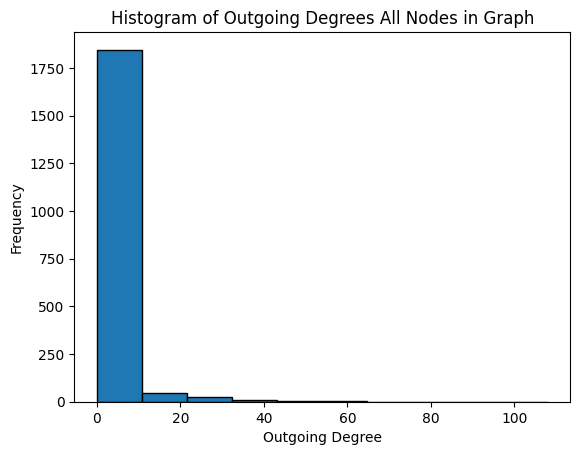

In [36]:
# Calculate outgoing degrees of nodes
out_degrees = [G.out_degree(node) for node in G.nodes]

# Plot histogram
plt.hist(out_degrees, bins=10, edgecolor="black")
plt.xlabel("Outgoing Degree")
plt.ylabel("Frequency")
plt.title("Histogram of Outgoing Degrees All Nodes in Graph")
plt.show()

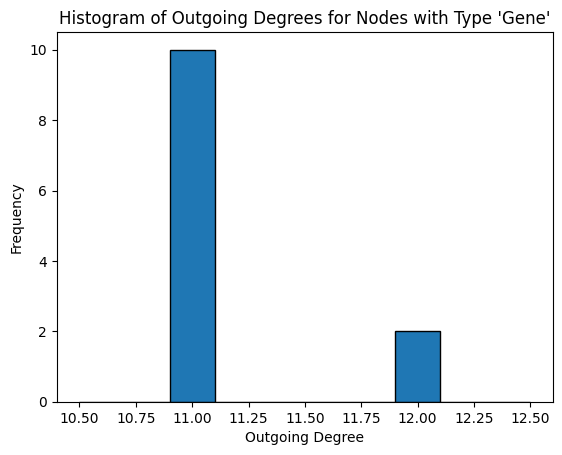

In [37]:
# Filter nodes based on type
compound_nodes = [node for node, data in G.nodes(data=True) if data["type"] == "Gene"]

# Calculate outgoing degrees of compound nodes
out_degrees = [G.out_degree(node) for node in compound_nodes]

# Plot histogram
plt.hist(out_degrees, bins=10, range=(10.5, max(out_degrees) + 0.5), edgecolor="black")
plt.xlabel("Outgoing Degree")
plt.ylabel("Frequency")
plt.title("Histogram of Outgoing Degrees for Nodes with Type 'Gene'")
plt.show()

In [38]:
degrees = dict(Counter(out_degrees))

for d in sorted(degrees)[10:]:
    print(d, degrees[d])

10 30
11 10
12 2


We'll start with the outgoing degrees from drugs:

In [39]:
drugs_in_pairs = {row['source'] for i, row in full_kg.loc[full_kg['edge_type'] == 'induces'].iterrows()}
drugs_in_dmdb = {row['source'] for i, row in validation_df.iterrows()}

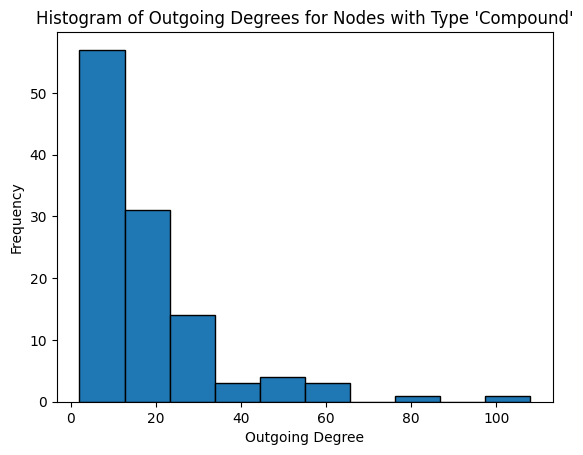

In [40]:
# Filter nodes based on type
compound_nodes = [node for node, data in G.nodes(data=True) if data["type"] == "Compound" and node in drugs_in_pairs]

# Calculate outgoing degrees of compound nodes
out_degrees = [G.out_degree(node) for node in compound_nodes]

# Plot histogram
plt.hist(out_degrees, bins=10, edgecolor="black")
plt.xlabel("Outgoing Degree")
plt.ylabel("Frequency")
plt.title("Histogram of Outgoing Degrees for Nodes with Type 'Compound'")
plt.show()

How many of these only have connections to (1) protein and (1) BP?

In [41]:
Counter(out_degrees)[2]

11

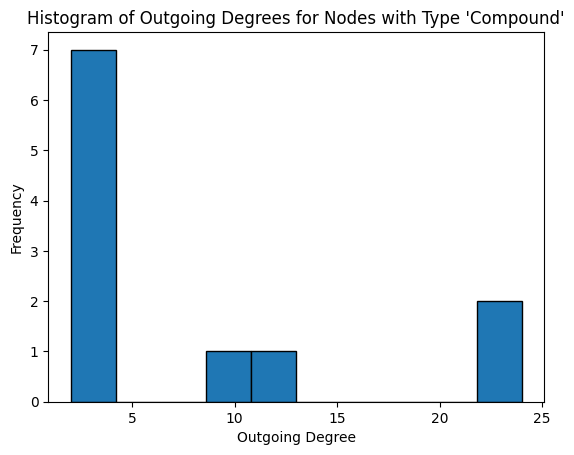

In [42]:
# Filter nodes based on type
compound_nodes = [node for node, data in G.nodes(data=True) if data["type"] == "Compound" and node in drugs_in_dmdb]

# Calculate outgoing degrees of compound nodes
out_degrees = [G.out_degree(node) for node in compound_nodes]

# Plot histogram
plt.hist(out_degrees, bins=10, edgecolor="black")
plt.xlabel("Outgoing Degree")
plt.ylabel("Frequency")
plt.title("Histogram of Outgoing Degrees for Nodes with Type 'Compound'")
plt.show()

In [43]:
Counter(out_degrees)[2]

4

What about the Biological Processes?

In [44]:
bps_in_pairs = {row['target'] for i, row in full_kg.loc[full_kg['edge_type'] == 'induces'].iterrows()}
bps_in_dmdb = {row['target'] for i, row in validation_df.iterrows()}

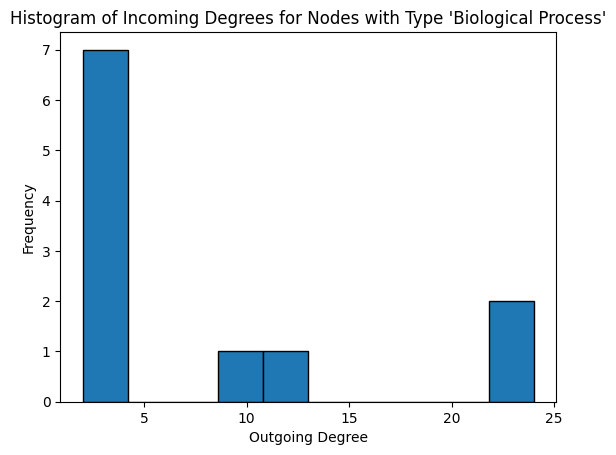

In [45]:
# Filter nodes based on type
bp_nodes = [node for node, data in G.nodes(data=True) if data["type"] == "Biological Process" and node in bps_in_pairs]

# Calculate outgoing degrees of compound nodes
in_degrees = [G.in_degree(node) for node in bp_nodes]

# Plot histogram
plt.hist(out_degrees, bins=10, edgecolor="black")
plt.xlabel("Outgoing Degree")
plt.ylabel("Frequency")
plt.title("Histogram of Incoming Degrees for Nodes with Type 'Biological Process'")
plt.show()

In [46]:
Counter(in_degrees)[2]

8

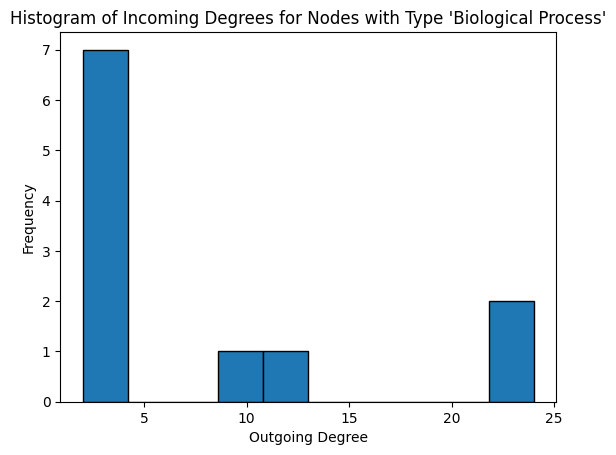

In [47]:
# Filter nodes based on type
bp_nodes = [node for node, data in G.nodes(data=True) if data["type"] == "Biological Process" and node in bps_in_dmdb]

# Calculate outgoing degrees of compound nodes
in_degrees = [G.in_degree(node) for node in bp_nodes]

# Plot histogram
plt.hist(out_degrees, bins=10, edgecolor="black")
plt.xlabel("Outgoing Degree")
plt.ylabel("Frequency")
plt.title("Histogram of Incoming Degrees for Nodes with Type 'Biological Process'")
plt.show()

In [48]:
Counter(in_degrees)[2]

8

In [49]:
Counter(in_degrees)

Counter({2: 8, 84: 1, 6: 1})

It seems that the validation pairs from the DrugMechDB are the ones with limited degrees.

Let's see what their connected proteins are connected to.

First we'll take all the nodes which have a degree of two, grab the proteins they're connected to, and then see what their degree is.

In [50]:
cnodes_with_out_degree_2 = [node for node in compound_nodes if G.out_degree(node) == 2]

In [51]:
prot_nodes = []

for starting_node in cnodes_with_out_degree_2:
    neighbors = nx.bfs_successors(G, starting_node, depth_limit=1)
    for _, connected_nodes in neighbors:
        prot_nodes.extend([node for node in connected_nodes if G.nodes[node]["type"] == "Gene"])

In [52]:
len(prot_nodes) == len(cnodes_with_out_degree_2)

True

In [53]:
len(set(prot_nodes)) == len(cnodes_with_out_degree_2)

False

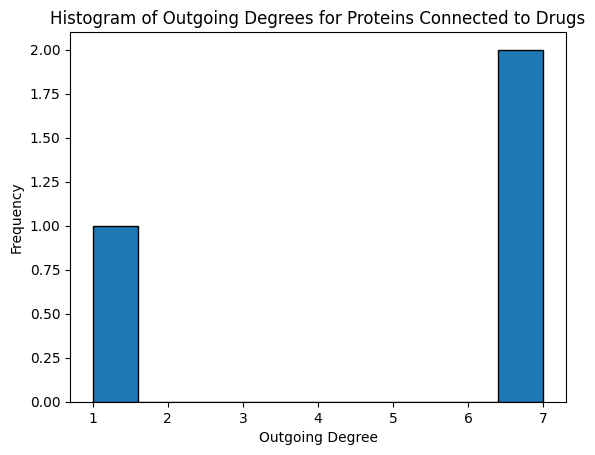

In [54]:
out_degrees_proteins = [G.out_degree(node) for node in set(prot_nodes)]

# Plot histogram
plt.hist(out_degrees_proteins, bins=10, edgecolor="black")
plt.xlabel("Outgoing Degree")
plt.ylabel("Frequency")
plt.title("Histogram of Outgoing Degrees for Proteins Connected to Drugs")
plt.show()

Are there any that only go to the GO BP and nothing else?

In [55]:
Counter(out_degrees_proteins)[1]

1

Okay, let's do it for the proteins connected to BPs:

In [56]:
bpnodes_with_out_degree_2 = [node for node in bp_nodes if G.in_degree(node) == 2]

In [57]:
prot_nodes = []

for starting_node in bpnodes_with_out_degree_2:
    neighbors = G.predecessors(starting_node)
    prot_nodes.extend([node for node in neighbors if G.nodes[node]["type"] == "Gene"])

In [58]:
len(prot_nodes) == len(bpnodes_with_out_degree_2)

True

In [59]:
len(set(prot_nodes)) == len(bpnodes_with_out_degree_2)

False

I keep the next part as outgoing degrees to see whether they go straight to GO BP or not.

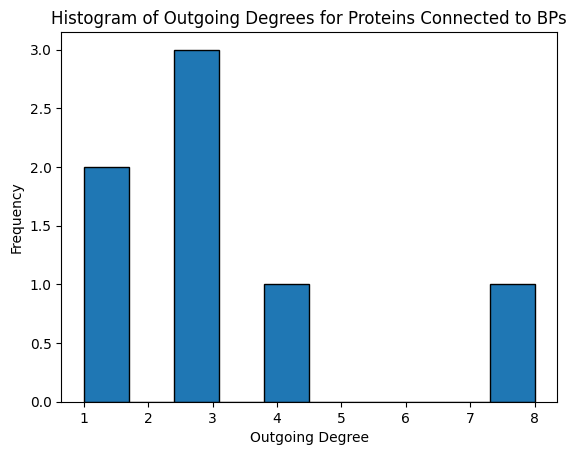

In [60]:
out_degrees_proteins = [G.out_degree(node) for node in set(prot_nodes)]

# Plot histogram
plt.hist(out_degrees_proteins, bins=10, edgecolor="black")
plt.xlabel("Outgoing Degree")
plt.ylabel("Frequency")
plt.title("Histogram of Outgoing Degrees for Proteins Connected to BPs")
plt.show()

Are there any that go straight to the GO BP?

In [61]:
Counter(out_degrees_proteins)[1]

2

Okay, it seems that only one option is a straight-shot. The others are not.

----------------------------------------

In [62]:
risky_edges = []

for source, target in G.edges():
    if source in compound_nodes and target in bp_nodes:
        risky_edges.append((source, target))

In [63]:
len(set(risky_edges))

14

In [64]:
len(set(risky_edges) & set(validation_moas.keys()))

13

Let's double check to ensure that all pairs are connected to the KG:

In [65]:
final_kg_df = pd.concat([final_kg_df, validation_df], ignore_index=True)

In [66]:
# get all of the proteins connected to other proteins
prots_connected = set()
for i, row in final_kg_df.loc[final_kg_df['edge_type'] == 'interacts'].iterrows():
    prots_connected.add(row['source'])
    prots_connected.add(row['target'])

In [67]:
# get all the BPs whose protein is also connected to other proteins
bp_nodes = {row['target'] for i, row in final_kg_df.loc[final_kg_df['edge_type'] == 'participates'].iterrows() if row['source'] in prots_connected}
# get all the drugs whose protein is also connected to other proteins
drug_nodes = {row['source'] for i, row in final_kg_df.loc[final_kg_df['edge_type'].isin({'downregulates', 'upregulates'})].iterrows() if row['target'] in prots_connected}

In [68]:
# get the drug-BP pairs
drugbp_pairs = final_kg_df.loc[final_kg_df['edge_type'] == 'induces']

In [69]:
len(drugbp_pairs)

936

In [70]:
drugbp_pairs.loc[drugbp_pairs['source'].isin(drug_nodes) & drugbp_pairs['target'].isin(bp_nodes)]

,source,target,edge_type,source_node_type,target_node_type
6580,pubchem.compound:10607,GO:0002376,induces,Compound,Biological Process
6581,pubchem.compound:10607,GO:0007010,induces,Compound,Biological Process
6582,pubchem.compound:10607,GO:0007049,induces,Compound,Biological Process
6583,pubchem.compound:10607,GO:0007155,induces,Compound,Biological Process
6584,pubchem.compound:10607,GO:0030154,induces,Compound,Biological Process
...,...,...,...,...,...
9084,pubchem.compound:33741,GO:0019233,induces,Compound,Biological Process
9085,pubchem.compound:24872560,GO:0006351,induces,Compound,Biological Process
9086,pubchem.compound:24872560,GO:0008283,induces,Compound,Biological Process
9087,pubchem.compound:5339,GO:0019370,induces,Compound,Biological Process
